In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.datasets import load_iris
from imblearn.over_sampling import BorderlineSMOTE as ImblearnBorderlineSMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

In [2]:
X, y = load_iris(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [4]:
class BorderlineSMOTE:
    def __init__(self, k_neighbors=5, m_neighbors=10):
        self.k_neighbors = k_neighbors
        self.m_neighbors = m_neighbors

    def fit_resample(self, X, y):
        classes, class_counts = np.unique(y, return_counts=True)
        majority_class = classes[np.argmax(class_counts)]
        minority_class = classes[np.argmin(class_counts)]

        minority_samples = X[y == minority_class]
        majority_samples = X[y == majority_class]

        n_minority_samples = minority_samples.shape[0]
        n_majority_samples = majority_samples.shape[0]
        n_to_generate = n_majority_samples - n_minority_samples

        if n_to_generate <= 0:
            return X, y

        nn_m = NearestNeighbors(n_neighbors=self.m_neighbors).fit(X)
        neighbors_m = nn_m.kneighbors(minority_samples, return_distance=False)

        danger_indices = []
        for i in range(n_minority_samples):
            majority_neighbors = sum(y[neighbors_m[i][1:]] == majority_class)
            if majority_neighbors > (self.m_neighbors / 2):
                danger_indices.append(i)
        
        danger_samples = minority_samples[danger_indices]
        if len(danger_samples) == 0:
            return X, y

        nn_k = NearestNeighbors(n_neighbors=self.k_neighbors).fit(minority_samples)
        neighbors_k = nn_k.kneighbors(danger_samples, return_distance=False)

        synthetic_samples = np.zeros((n_to_generate, X.shape[1]))

        for i in range(n_to_generate):
            sample_idx = np.random.randint(0, len(danger_samples))
            neighbor_idx = np.random.choice(neighbors_k[sample_idx][1:])
            
            sample = danger_samples[sample_idx]
            neighbor = minority_samples[neighbor_idx]
            
            diff = neighbor - sample
            gap = np.random.rand()
            synthetic_samples[i] = sample + gap * diff

        X_resampled = np.vstack((X, synthetic_samples))
        y_resampled = np.hstack((y, np.full(n_to_generate, minority_class)))
        return X_resampled, y_resampled

In [5]:
borderline_smote = BorderlineSMOTE(k_neighbors=3, m_neighbors=10)

In [6]:
X_train_resampled, y_train_resampled = borderline_smote.fit_resample(X, y)

In [7]:
print("y_train:", Counter(y_train))
print("y_train_resampled:", Counter(y_train_resampled))

y_train: Counter({2: 44, 0: 42, 1: 41})
y_train_resampled: Counter({0: 50, 1: 50, 2: 50})


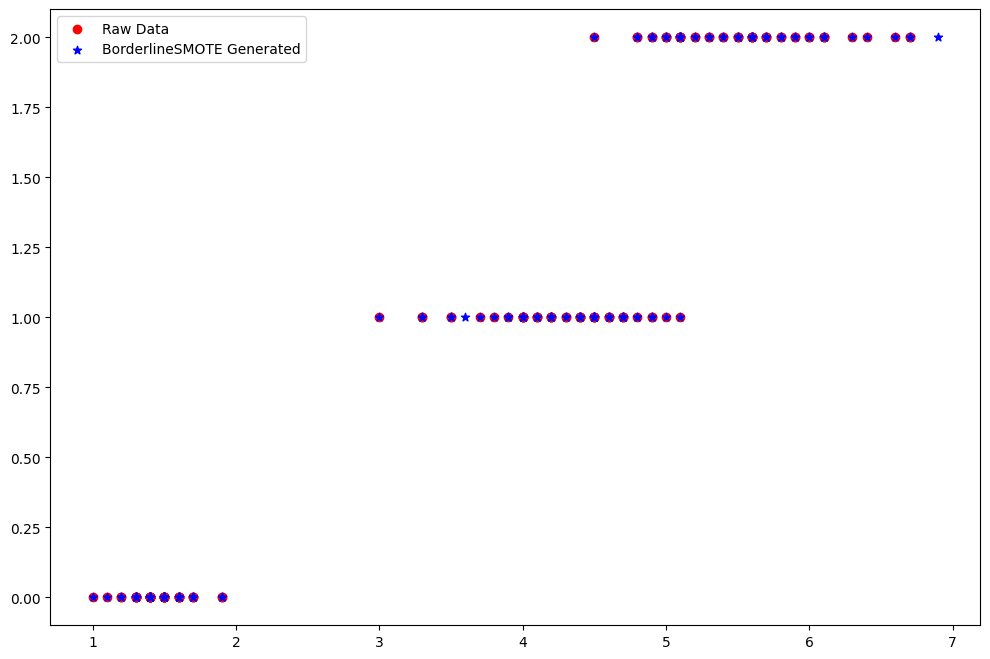

In [8]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train[:, 2], y_train, color="r", marker="o")
plt.scatter(X_train_resampled[:, 2], y_train_resampled, color="b", marker="*")
plt.legend(["Raw Data", "BorderlineSMOTE Generated"])
plt.show()